In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Activation, GlobalAveragePooling2D, UpSampling2D, Lambda
from keras.layers.core import Dropout, Reshape
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import Initializer
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import pydot
import graphviz
from keras.utils import plot_model
import glob
import bcolz
import math

Using TensorFlow backend.


In [2]:
#Open dataset
x_all = bcolz.open('dataset/x_train.bc')[:]
y_all = bcolz.open('dataset/y_train_encoded.bc')[:]

x_all = x_all/255.0
num_elements = x_all.shape[1] * x_all.shape[2]

#Split into train, validation, and test set
x_train = x_all[:450]
y_train = y_all[:450]
y_train = np.reshape(y_train,(len(y_train),num_elements))
y_train = np.expand_dims(y_train,axis=2)

x_validation = x_all[450:625]
y_validation = y_all[450:625]
y_validation = np.reshape(y_validation,(len(y_validation),num_elements))
y_validation = np.expand_dims(y_validation,axis=2)

x_test = x_all[625:]
y_test = y_all[625:]
y_test = np.reshape(y_test,(len(y_test),num_elements))
y_test = np.expand_dims(y_test,axis=2)

x_train.shape, y_train.shape, y_all.shape, np.amax(x_all)

((450, 384, 512, 3), (450, 196608, 1), (701, 384, 512), 1.0)

In [4]:
#Define the CRN
L = Input(x_train.shape[1:])
sc = 64 #Scale factor

#M0
##Input layer - Downsample L
L_down = AveragePooling2D(padding='same')(L)
n = int(math.log(sc,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down) 
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(L_down)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M1
#Upsample F0
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L)   #Downsample L
n = int(math.log(sc/2,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)    
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M2
#Upsample F1
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/4,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M3
#Upsample F2
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/8,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(512, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(512, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M4
#Upsample F3
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/16,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(512, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(512, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M5
#Upsample F4
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/32,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(128, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(128, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M6
#Upsample F5
x = UpSampling2D()(x)
#Input layer
x = Concatenate()([L, x]) #Concatenate L and Fx_up
#Intermediate layer
x = Conv2D(32, (3,3), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer - Apply 1x1 conv to F6
x = Conv2D(32, (1,1), padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(0.0001))(x)
x = Reshape((-1, 32))(x)
x = Activation('softmax')(x)

#Scale output so we get 0 to 255
#n1_out = Lambda(lambda x: (x+1)*127.5)(x)
#n1_out = Lambda(lambda x: (x+1)/2.0*255.0)(x)

In [5]:
model = Model(L, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(),
              metrics=["accuracy"])
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            patience=45, 
                                            verbose=1, mode='auto')
#model.summary()

In [6]:
model.optimizer = Adam(0.00001)
model.fit(x_train, y_train, batch_size = 5, epochs = 200, 
          shuffle = True,
          validation_data=(x_validation, y_validation),
          callbacks=[earlyStopping])

Train on 450 samples, validate on 175 samples
Epoch 1/200
450/450 [==============================] - 83s - loss: 3.3162 - acc: 0.5811 - val_loss: 4.0071 - val_acc: 0.4211
Epoch 2/200
450/450 [==============================] - 77s - loss: 2.9322 - acc: 0.6956 - val_loss: 3.3710 - val_acc: 0.6200
Epoch 3/200
450/450 [==============================] - 77s - loss: 2.8135 - acc: 0.7275 - val_loss: 2.9896 - val_acc: 0.7107
Epoch 4/200
450/450 [==============================] - 77s - loss: 2.7502 - acc: 0.7424 - val_loss: 2.8413 - val_acc: 0.7293
Epoch 5/200
450/450 [==============================] - 77s - loss: 2.6913 - acc: 0.7578 - val_loss: 2.7931 - val_acc: 0.7433
Epoch 6/200
450/450 [==============================] - 77s - loss: 2.6404 - acc: 0.7694 - val_loss: 2.6624 - val_acc: 0.7591
Epoch 7/200
450/450 [==============================] - 77s - loss: 2.6042 - acc: 0.7785 - val_loss: 2.6612 - val_acc: 0.7623
Epoch 8/200
450/450 [==============================] - 77s - loss: 2.5501 - acc

450/450 [==============================] - 77s - loss: 1.7058 - acc: 0.9201 - val_loss: 2.0499 - val_acc: 0.8283
Epoch 66/200
450/450 [==============================] - 77s - loss: 1.7060 - acc: 0.9186 - val_loss: 2.0372 - val_acc: 0.8293
Epoch 67/200
450/450 [==============================] - 77s - loss: 1.6890 - acc: 0.9213 - val_loss: 2.0422 - val_acc: 0.8286
Epoch 68/200
450/450 [==============================] - 77s - loss: 1.6821 - acc: 0.9223 - val_loss: 2.0315 - val_acc: 0.8304
Epoch 69/200
450/450 [==============================] - 77s - loss: 1.6834 - acc: 0.9201 - val_loss: 2.0475 - val_acc: 0.8248
Epoch 70/200
450/450 [==============================] - 77s - loss: 1.6787 - acc: 0.9204 - val_loss: 2.0374 - val_acc: 0.8264
Epoch 71/200
450/450 [==============================] - 77s - loss: 1.6704 - acc: 0.9211 - val_loss: 2.0222 - val_acc: 0.8292
Epoch 72/200
450/450 [==============================] - 77s - loss: 1.6655 - acc: 0.9212 - val_loss: 2.0118 - val_acc: 0.8306
Epoch

450/450 [==============================] - 77s - loss: 1.3651 - acc: 0.9469 - val_loss: 1.8598 - val_acc: 0.8314
Epoch 130/200
450/450 [==============================] - 77s - loss: 1.3595 - acc: 0.9476 - val_loss: 1.8451 - val_acc: 0.8344
Epoch 131/200
450/450 [==============================] - 77s - loss: 1.3560 - acc: 0.9477 - val_loss: 1.8409 - val_acc: 0.8342
Epoch 132/200
450/450 [==============================] - 77s - loss: 1.3589 - acc: 0.9461 - val_loss: 1.8499 - val_acc: 0.8328
Epoch 133/200
450/450 [==============================] - 77s - loss: 1.3533 - acc: 0.9469 - val_loss: 1.8431 - val_acc: 0.8324
Epoch 134/200
450/450 [==============================] - 77s - loss: 1.3511 - acc: 0.9468 - val_loss: 1.8476 - val_acc: 0.8311
Epoch 135/200
450/450 [==============================] - 77s - loss: 1.3480 - acc: 0.9467 - val_loss: 1.8373 - val_acc: 0.8335
Epoch 136/200
450/450 [==============================] - 77s - loss: 1.3372 - acc: 0.9490 - val_loss: 1.8276 - val_acc: 0.834

450/450 [==============================] - 77s - loss: 1.1667 - acc: 0.9600 - val_loss: 1.7598 - val_acc: 0.8334
Epoch 194/200
450/450 [==============================] - 77s - loss: 1.1703 - acc: 0.9581 - val_loss: 1.7693 - val_acc: 0.8313
Epoch 195/200
450/450 [==============================] - 77s - loss: 1.1746 - acc: 0.9560 - val_loss: 1.7679 - val_acc: 0.8326
Epoch 196/200
450/450 [==============================] - 77s - loss: 1.1642 - acc: 0.9586 - val_loss: 1.7407 - val_acc: 0.8352
Epoch 197/200
450/450 [==============================] - 77s - loss: 1.1538 - acc: 0.9615 - val_loss: 1.7393 - val_acc: 0.8367
Epoch 198/200
450/450 [==============================] - 77s - loss: 1.1496 - acc: 0.9620 - val_loss: 1.7373 - val_acc: 0.8360
Epoch 199/200
450/450 [==============================] - 77s - loss: 1.1458 - acc: 0.9627 - val_loss: 1.7350 - val_acc: 0.8372
Epoch 200/200
450/450 [==============================] - 77s - loss: 1.1424 - acc: 0.9629 - val_loss: 1.7299 - val_acc: 0.837

In [7]:
evaluation = model.evaluate(x_test,y_test, batch_size=5, verbose=1)
print('Loss: %.2f Accuracy: %.2f%%' % (evaluation[0], evaluation[1]*100.0))

76/76 [==============================] - 3s     
Loss: 1.65 Accuracy: 85.16%


# Let's see some comparisons

In [8]:
#First we need some functions that map our output to the color map
def get_color(file):
    splitted=[]
    for i in open(file):
        colors = i.strip().split('\t')
        for j in colors[0]:
            line = colors[0].split(' ')
        line = list(map(int, line))
        splitted.append(line)
    return splitted

def code_to_color(mat,code_color):
    mat_reshaped = mat.reshape(x_all.shape[1],x_all.shape[2])
    #We want the output to be 3 channels
    color_map = np.zeros((x_all.shape[1],x_all.shape[2],3), 'uint8')
    for i in range(x_all.shape[1]): 
        for j in range(x_all.shape[2]):
            color = code_color[mat_reshaped[i,j]]
            color_map[i,j] = color
    return color_map

In [9]:
#Now use the functions to link the code numbers and colors
color = get_color('label_colors.txt')
code_color = {i:j for i,j in enumerate(color)}

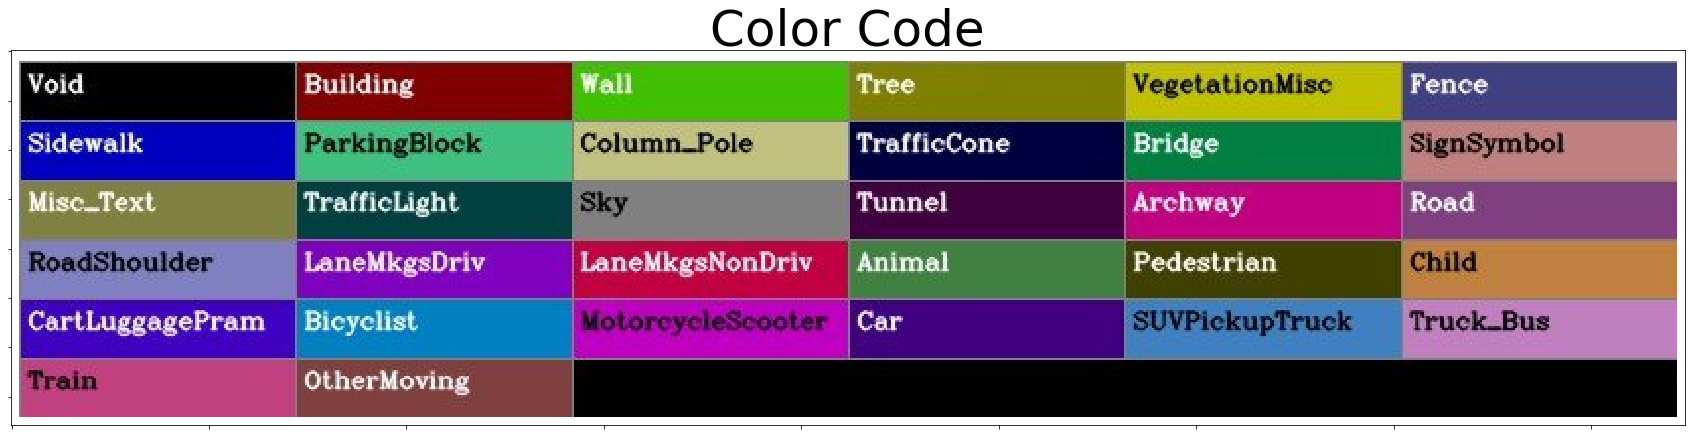

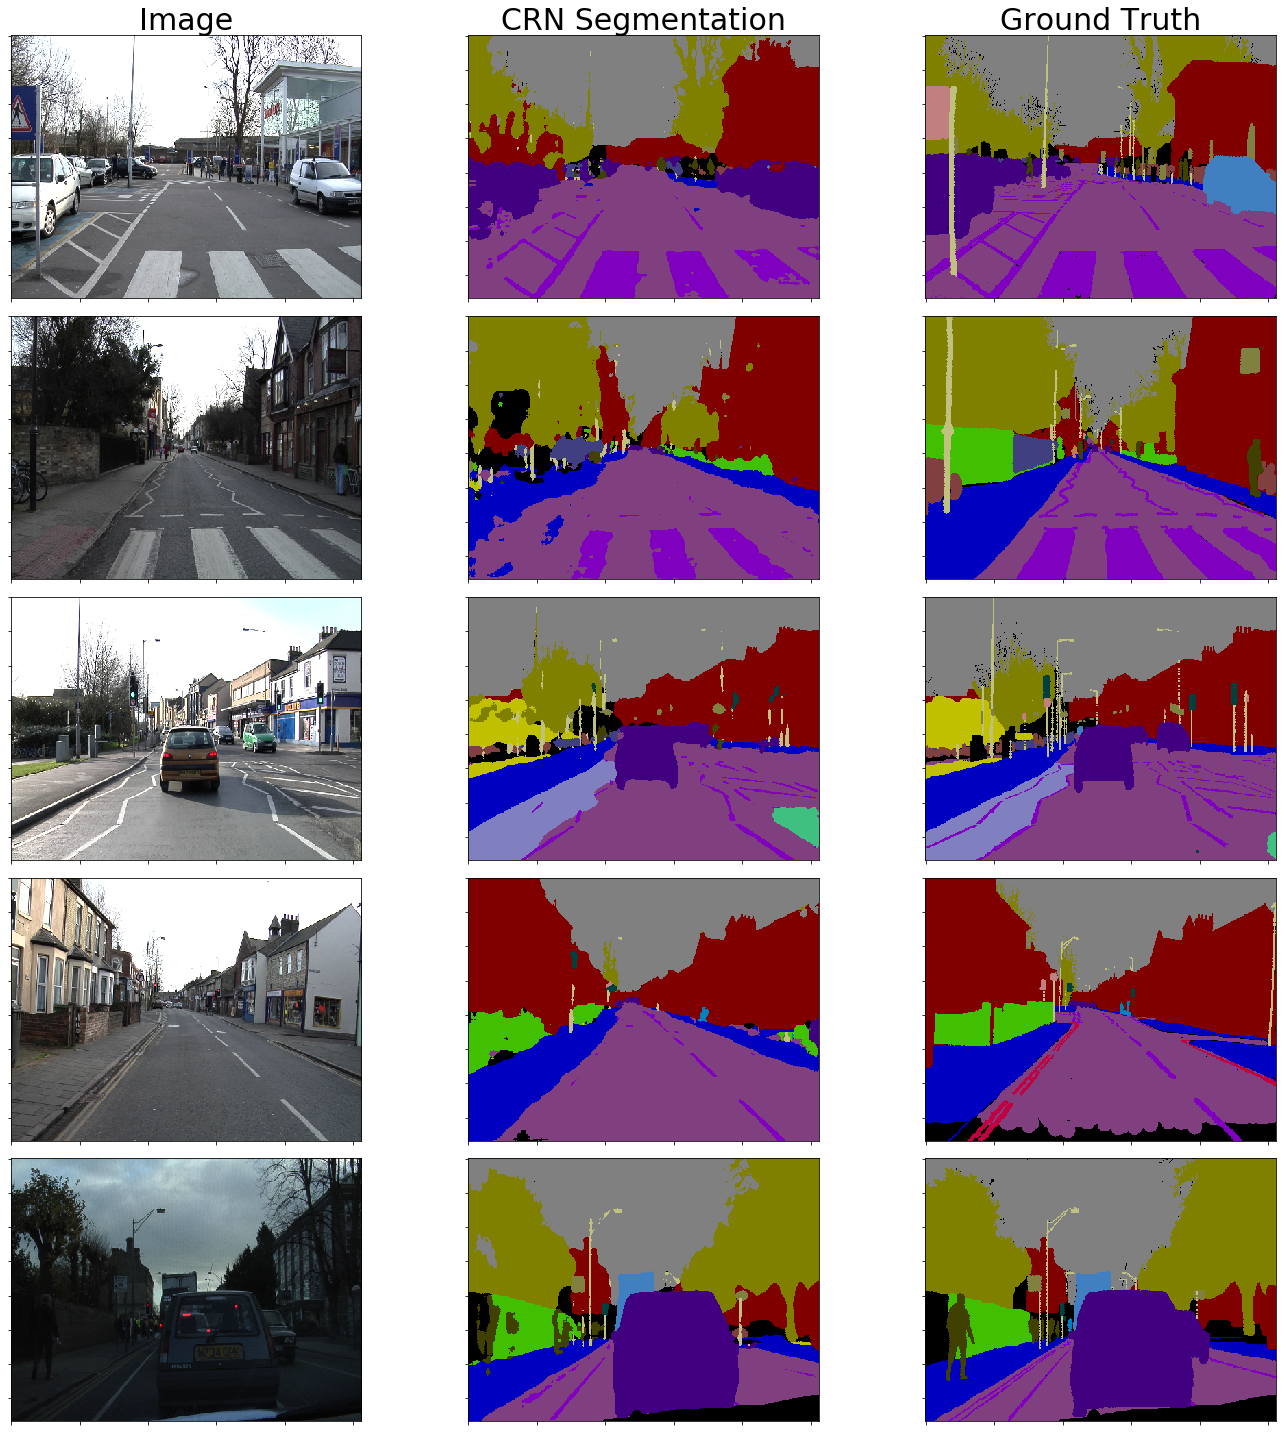

In [10]:
#Show CamVid color code
cc = Image.open('images/color_code.png')
fig,axis = plt.subplots(nrows=1, ncols=1, figsize=(30,30))
axis.set_title('Color Code',fontsize=50)
axis.imshow(cc);
axis.set_yticklabels([]);
axis.set_xticklabels([]);

#Show comparisons
num_pred = 5
columns = ['{}'.format(col) for col in ['Image', 'CRN Segmentation', 'Ground Truth']]
fig,axis = plt.subplots(nrows=num_pred, ncols=3, figsize=(20,20))
for ax,col in zip(axis[0], columns):
    ax.set_title(col,fontsize=30)
    
for i in range(num_pred):
    random_index = np.random.randint(0,76)
    img = np.expand_dims(x_test[random_index],axis=0)
    predictions = model.predict(img)
    predictions_arg = np.argmax(predictions, axis=-1)
    color_coded = code_to_color(predictions_arg[0], code_color)
    ground_truth = code_to_color(y_test[random_index], code_color);

    axis[i,0].imshow(x_test[random_index])
    axis[i,1].imshow(color_coded)
    axis[i,2].imshow(ground_truth)
    
    axis[i,0].set_yticklabels([])
    axis[i,0].set_xticklabels([])
    axis[i,1].set_yticklabels([])
    axis[i,1].set_xticklabels([])
    axis[i,2].set_yticklabels([])
    axis[i,2].set_xticklabels([])

plt.tight_layout()
plt.show()